# Оглавление:  <a class="anchor" id="s0"></a>
1. [Введение](#Введение)  
    1.1. [План](#План)
2. [Подготовка](#Подготовка)  
    2.1. [Функции](#Функции)  
    2.2. [Константы](#Константы)  
    2.3. [Переменные](#Переменные)  
3. [Изучение данных](#s1)  
    3.1. [Электроды](#Электроды)  
    3.2. [Сыпучие материалы (объем)](#s2)  
    3.3. [Сыпучие материалы (время)](#s3)  
    3.4. [Газ](#Газ)  
    3.5. [Температура (target)](#s4)    
    3.6. [Проволока (объем)](#s5)  
    3.7. [Проволока (время)](#s6)  
    3.8. [Вывод](#Вывод)  
4. [Подготовка данных](#s7)  
    4.1. [Вывод](#s8)  
5. [Обучение моделей](#s9)  
    5.1. [Проверка на адекватность](#s10)  
    5.2. [Значимость признаков](#s11)  
    5.3. [Вывод](#s12)  
6. [Отчет](#Отчет)

[Вернуться к оглавлению](#s0)

# Введение 

<br>
<font size=+3><b>Промышленность — задача проекта</b></font> 
<br>
<br>  
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.
<br>  
<br>
<font size=+2>Описание этапа обработки</font>  
<br>
<br>  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

<br> 
<font size=+2>Описание данных</font>  
<br>
<br> 
Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

[Вернуться к оглавлению](#s0)

## План 

    1. Знакомство с данными.
        1. Осмотр данных
        2. Исправление ошибок
        3. Поверхностный разведочный анализ данных
        4. Вывод
    2. Подготовка данных
        1. Формирование обобщеного датасета
        2. Выделение целевого признака
        3. Отбор подходящих признаков для обучения
        4. Приведение датасета в подходящий для обучения моделей вид
        5. Разделение на обучающую и тестовую выборку
        6. Вывод
    3. Обучение моделей        
        2. Обучение моделей с кросс-валидацией        
        3. Проверка на тестовой выборке
        4. Проверка на адекватность
        5. Вывод    
    4. Отчет

[Вернуться к оглавлению](#s0)

# Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import (RandomizedSearchCV,
    train_test_split, GridSearchCV, cross_val_score)
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import (
    LinearRegression, Ridge)
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  

In [2]:
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

[Вернуться к оглавлению](#s0)

## Функции

In [3]:
def format_time(data, vals): # Привести время в нужный формат
    for i in vals:
        data[i] = pd.to_datetime(
            data[i], format='%Y-%m-%d %H:%M:%S')

In [4]:
def varname(variable): # Достать имя переменной в str
    for name in list(globals().keys()):
        expression = f'id({name})'
        if id(variable) == eval(expression):
            return name

In [5]:
def check_duplicates(data, vals): # Проверка на дубликаты 
    if data.duplicated().sum() == 0:
        print(f'No duplicates in {varname(data)}')
    else:
        print(data.duplicated().sum(),
              f'duplicates in {varname(data)}')
    for i in vals:
        if data[i].dropna().duplicated().sum() == 0:
            print(f'No duplicates in {varname(data)}[{i}]')
        else:
            print(data[i].dropna().duplicated().sum(),
                  f'duplicates in {varname(data)}[{i}]')

## Константы

In [6]:
RANDOM_STATE = 150523
TEST_SIZE = 0.25
CV = 5

[Вернуться к оглавлению](#s0)

## Переменные

In [7]:
temp = [] # Для временного хранения необходимых для работы данных
keys = {} # Для сбора и последующего сравнения ключей
datasets = [] # Для хранения имен всех датасетов под рукой

[Вернуться к оглавлению](#s0)

# Изучение данных <a class="anchor" id="s1"></a>

In [8]:
electrodes = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
temperature = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [9]:
datasets = [electrodes, bulk, bulk_time, gas, temperature, wire, wire_time]

[Вернуться к оглавлению](#s0)

## Электроды

In [10]:
electrodes.head(20)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0     1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1     1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2     1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3     1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4     1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5     2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6     2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   
7     2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.710297   
8     2  2019-05-03 11:49:48  2019-05-03 11:53:18           0.786322   
9     3  2019-05-03 12:06:54  2019-05-03 12:11:34           1.101678   
10    3  2019-05-03 12:13:52  2019-05-03 12:15:56           0.542675   
11    3  2019-05-03 12:18:56  2019-05-03 12:20:45           0.774632   
12    3  2019-05-03 12:25:43  2019-05-03 12:27:00           1.222963   
13    3  2019-05-03 12:31:14  2019-05-03 12:32:19           0.421693   
14    4  2019-05-03 12:39:37  2019-05-03 12:43:04           0.642946   
15    4  2019-05-03 12:44:47  2019-05-03 12:46:26           0.310693   
16    4  2019-05-03 12:48:14  2019-05-03 12:50:51           0.887855   
17    4  2019-05-03 12:53:12  2019-05-03 12:57:50           0.864995   
18    5  2019-05-03 13:11:13  2019-05-03 13:15:24           0.324563   
19    5  2019-05-03 13:18:21  2019-05-03 13:20:33           0.573810   

    Реактивная мощность  
0              0.211253  
1              0.477438  
2              0.430460  
3              0.379979  
4              0.643691  
5              0.220351  
6              0.205527  
7              0.484962  
8              0.542517  
9              0.820856  
10             0.474673  
11             0.505690  
12             0.863676  
13             0.272562  
14             0.516071  
15             0.241781  
16             0.644479  
17             0.654661  
18             0.279102  
19             0.439417

Каждая партия проходит несколько этапов нагрева. Проверим это утверждение.

In [11]:
electrodes.key.value_counts().sort_values()

530      1
2738     1
943      1
1169     1
49       1
        ..
46      13
2567    14
1513    15
1689    15
2108    16
Name: key, Length: 3214, dtype: int64

Утверждение ложное. Не каждая партия проходит несколько этапов нагрева.

In [12]:
electrodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Нужно сменить имена

In [13]:
electrodes = electrodes.rename(columns={
    'Начало нагрева дугой':'start_of_heating',
    'Конец нагрева дугой':'end_of_heating',
    'Активная мощность':'active_power',
    'Реактивная мощность':'reactive_power'})

Нужно привести время к правильному формату

In [14]:
format_time(electrodes, ['start_of_heating','end_of_heating'])

Проверка на дубликаты

In [15]:
check_duplicates(electrodes, ['start_of_heating', 'end_of_heating'])

No duplicates in electrodes
No duplicates in electrodes[start_of_heating]
No duplicates in electrodes[end_of_heating]


In [16]:
electrodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14876 non-null  int64         
 1   start_of_heating  14876 non-null  datetime64[ns]
 2   end_of_heating    14876 non-null  datetime64[ns]
 3   active_power      14876 non-null  float64       
 4   reactive_power    14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [17]:
electrodes.describe()

key  active_power  reactive_power
count  14876.000000  14876.000000    14876.000000
mean    1615.220422      0.662752        0.438986
std      934.571502      0.258885        5.873485
min        1.000000      0.223120     -715.479924
25%      806.000000      0.467115        0.337175
50%     1617.000000      0.599587        0.441639
75%     2429.000000      0.830070        0.608201
max     3241.000000      1.463773        1.270284

Обнаружено аномальное значение реактивной мощности. Проведем дополнительную проверку и удалим аномалии

In [18]:
electrodes[electrodes['reactive_power'] <= 0]

key    start_of_heating      end_of_heating  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479924

In [19]:
electrodes.loc[9775:9785]

key    start_of_heating      end_of_heating  active_power  \
9775  2115 2019-07-28 01:38:20 2019-07-28 01:40:18      0.560170   
9776  2115 2019-07-28 01:46:45 2019-07-28 01:49:09      0.343438   
9777  2115 2019-07-28 01:58:40 2019-07-28 01:59:41      0.707937   
9778  2116 2019-07-28 02:07:12 2019-07-28 02:09:14      0.787549   
9779  2116 2019-07-28 02:13:10 2019-07-28 02:15:25      0.580263   
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   
9781  2116 2019-07-28 02:29:11 2019-07-28 02:30:18      0.563641   
9782  2117 2019-07-28 02:43:21 2019-07-28 02:45:17      0.717442   
9783  2117 2019-07-28 02:49:01 2019-07-28 02:52:22      1.136919   
9784  2117 2019-07-28 02:57:30 2019-07-28 03:01:04      0.456681   
9785  2118 2019-07-28 03:07:25 2019-07-28 03:09:20      0.637519   

      reactive_power  
9775        0.435785  
9776        0.230592  
9777        0.460147  
9778        0.693881  
9779        0.411498  
9780     -715.479924  
9781        0.408513  
9782        0.463680  
9783        0.740858  
9784        0.365049  
9785        0.460808

In [20]:
electrodes = electrodes.drop(
    index=electrodes[electrodes['reactive_power'] <= 0].index,
    axis=0)

Аномалия была только одна

In [21]:
electrodes.corr()

key  active_power  reactive_power
key             1.000000     -0.010226       -0.013169
active_power   -0.010226      1.000000        0.966373
reactive_power -0.013169      0.966373        1.000000

Корреляция между active_power и reactive_power очень высокая положительная

In [22]:
keys['electrodes'] = electrodes.key.nunique()
keys

{'electrodes': 3214}

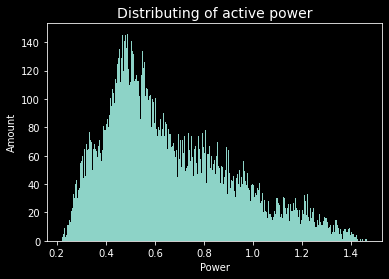

In [23]:
plt.hist(electrodes['active_power'], bins = 300)
plt.xlabel('Power')
plt.ylabel('Amount')
plt.title('Distributing of active power', size=14);

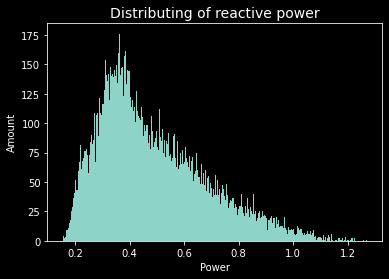

In [24]:
plt.hist(electrodes['reactive_power'], bins = 300)
plt.xlabel('Power')
plt.ylabel('Amount')
plt.title('Distributing of reactive power', size=14);

Распределение мощностей нагрева нормальное, смещено влево

- Имена изменены  
- Формат времени изменен  
- Дубликатов нет  
- Пропусков нет  
- Аномальные значения удалены

[Вернуться к оглавлению](#s0)

## Сыпучие материалы (объем) <a class="anchor" id="s2"></a>

In [25]:
bulk.head(20)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0     1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1     2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2     3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3     4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4     5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5     6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6     7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
7     8     NaN     NaN     NaN    99.0     NaN     NaN     NaN     NaN   
8     9     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
9    10     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
10   11     NaN     NaN     NaN    69.0     NaN     NaN     NaN     NaN   
11   12    46.0     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
12   13     NaN     NaN     NaN     NaN     NaN    72.0     NaN     NaN   
13   14     NaN     NaN    71.0     NaN     NaN     NaN     NaN     NaN   
14   15     NaN     NaN     NaN     NaN     NaN    77.0     NaN     NaN   
15   16     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
16   17     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
17   18     NaN     NaN     NaN     NaN     NaN    76.0     NaN     NaN   
18   19     NaN     NaN     NaN     NaN     NaN   219.0     NaN     NaN   
19   20     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

    Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0      NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1      NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2      NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3      NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4      NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5      NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6      NaN      NaN      NaN    204.0      NaN    152.0    154.0  
7      NaN      NaN      NaN    410.0      NaN    252.0    153.0  
8      NaN      NaN      NaN    107.0      NaN     99.0    203.0  
9      NaN      NaN      NaN    203.0      NaN    102.0    204.0  
10     NaN      NaN      NaN    207.0      NaN    101.0    202.0  
11     NaN      NaN      NaN    618.0      NaN    406.0    203.0  
12     NaN      NaN      NaN    410.0      NaN    151.0    204.0  
13     NaN      NaN      NaN    204.0      NaN    152.0    203.0  
14     NaN      NaN      NaN      NaN      NaN    251.0    203.0  
15     NaN      NaN      NaN    206.0      NaN    100.0    203.0  
16     NaN      NaN      NaN      NaN      NaN    153.0    202.0  
17     NaN      NaN      NaN    206.0      NaN    103.0    203.0  
18     NaN      NaN      NaN      NaN      NaN      NaN      NaN  
19     NaN      NaN      NaN      NaN      NaN    249.0      NaN

Поменяем имена

In [26]:
for i in range(1,16):
    bulk = bulk.rename(columns={bulk.columns[i]:f'bulk_{i}'})

In [27]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [28]:
bulk.key.nunique()

3129

Все ключи уникальны

In [29]:
bulk.duplicated().sum()

0

Полных дубликатов нет

In [30]:
bulk.describe()

key      bulk_1      bulk_2       bulk_3       bulk_4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          bulk_11      bulk_12     bulk_13      bulk_14      bulk_15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [31]:
keys['bulk'] = bulk.key.nunique()
keys

{'electrodes': 3214, 'bulk': 3129}

Уже заметно разное количество ключей, значит в некоторые партии не добавлялись присадки, либо информация потеряна

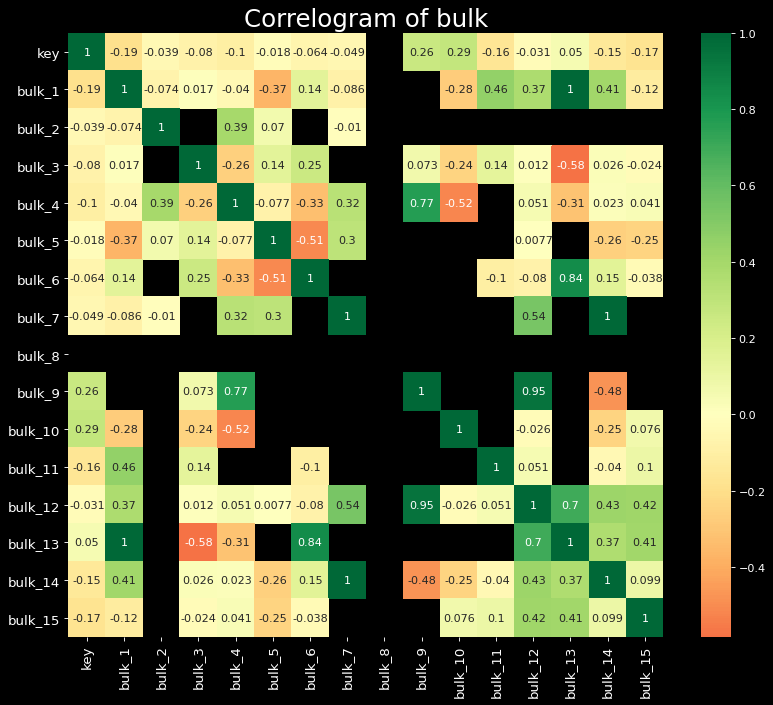

In [32]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(
    bulk.corr(), 
    xticklabels=bulk.corr().columns, 
    yticklabels=bulk.corr().columns, 
    cmap='RdYlGn', 
    center=0, 
    annot=True)

plt.title('Correlogram of bulk', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

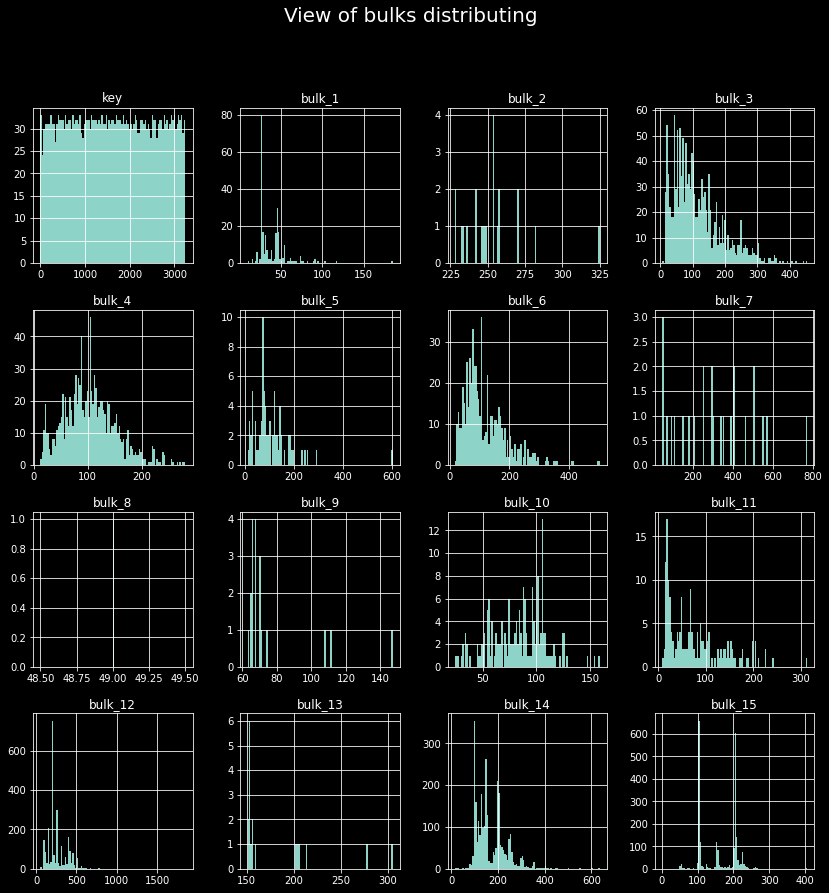

In [33]:

bulk.hist(figsize=(14,14), bins= 100)
plt.suptitle('View of bulks distributing', size= 20);

- Имена изменены
- Ключи уникальны, что значит присадки добавляются единожды
- Дубликатов нет
- Корреляции присутствуют разной силы

В разные партии подается разное количество разных примесей

[Вернуться к оглавлению](#s0)

## Сыпучие материалы (время) <a class="anchor" id="s3"></a>

In [34]:
bulk_time.head(20)

key               Bulk 1 Bulk 2               Bulk 3               Bulk 4  \
0     1                  NaN    NaN                  NaN  2019-05-03 11:28:48   
1     2                  NaN    NaN                  NaN  2019-05-03 11:36:50   
2     3                  NaN    NaN                  NaN  2019-05-03 12:32:39   
3     4                  NaN    NaN                  NaN  2019-05-03 12:43:22   
4     5                  NaN    NaN                  NaN  2019-05-03 13:30:47   
5     6                  NaN    NaN                  NaN  2019-05-03 13:57:27   
6     7                  NaN    NaN                  NaN  2019-05-03 14:18:58   
7     8                  NaN    NaN                  NaN  2019-05-03 15:17:58   
8     9                  NaN    NaN                  NaN  2019-05-03 16:03:08   
9    10                  NaN    NaN                  NaN                  NaN   
10   11                  NaN    NaN                  NaN  2019-05-03 17:32:23   
11   12  2019-05-03 17:42:46    NaN                  NaN  2019-05-03 17:52:57   
12   13                  NaN    NaN                  NaN                  NaN   
13   14                  NaN    NaN  2019-05-03 20:40:25                  NaN   
14   15                  NaN    NaN                  NaN                  NaN   
15   16                  NaN    NaN                  NaN                  NaN   
16   17                  NaN    NaN                  NaN                  NaN   
17   18                  NaN    NaN                  NaN                  NaN   
18   19                  NaN    NaN                  NaN                  NaN   
19   20                  NaN    NaN                  NaN                  NaN   

   Bulk 5               Bulk 6 Bulk 7 Bulk 8 Bulk 9 Bulk 10 Bulk 11  \
0     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
1     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
2     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
3     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
4     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
5     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
6     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
7     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
8     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
9     NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
10    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
11    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
12    NaN  2019-05-03 19:09:15    NaN    NaN    NaN     NaN     NaN   
13    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
14    NaN  2019-05-03 21:36:10    NaN    NaN    NaN     NaN     NaN   
15    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
16    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   
17    NaN  2019-05-03 23:40:36    NaN    NaN    NaN     NaN     NaN   
18    NaN  2019-05-04 01:14:08    NaN    NaN    NaN     NaN     NaN   
19    NaN                  NaN    NaN    NaN    NaN     NaN     NaN   

                Bulk 12 Bulk 13              Bulk 14              Bulk 15  
0   2019-05-03 11:24:31     NaN  2019-05-03 11:14:50  2019-05-03 11:10:43  
1   2019-05-03 11:53:30     NaN  2019-05-03 11:48:37  2019-05-03 11:44:39  
2   2019-05-03 12:27:13     NaN  2019-05-03 12:21:01  2019-05-03 12:16:16  
3   2019-05-03 12:58:00     NaN  2019-05-03 12:51:11  2019-05-03 12:46:36  
4   2019-05-03 13:30:47     NaN  2019-05-03 13:34:12  2019-05-03 13:30:47  
5   2019-05-03 13:48:52     NaN  2019-05-03 14:09:42  2019-05-03 14:03:15  
6   2019-05-03 14:41:26     NaN  2019-05-03 14:30:50  2019-05-03 14:27:16  
7   2019-05-03 15:17:58     NaN  2019-05-03 15:13:18  2019-05-03 15:05:33  
8   2019-05-03 16:03:08     NaN  2019-05-03 16:00:16  2019-05-03 15:52:39  
9   2019-05-03 16:38:11     NaN  2019-05-03 16:34:

In [35]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [36]:
temp = list(bulk_time.columns)
temp.pop(0)
temp

['Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 8',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15']

Изменим формат времени

In [37]:
format_time(bulk_time, temp)

Изменим имена

In [38]:
for i in range(1,16):
    bulk_time = bulk_time.rename(columns={bulk_time.columns[i]:f'bulk_time_{i}'})

In [39]:
temp = list(bulk_time.columns)
temp.pop(0)
temp

['bulk_time_1',
 'bulk_time_2',
 'bulk_time_3',
 'bulk_time_4',
 'bulk_time_5',
 'bulk_time_6',
 'bulk_time_7',
 'bulk_time_8',
 'bulk_time_9',
 'bulk_time_10',
 'bulk_time_11',
 'bulk_time_12',
 'bulk_time_13',
 'bulk_time_14',
 'bulk_time_15']

In [40]:
check_duplicates(bulk_time, temp)

No duplicates in bulk_time
No duplicates in bulk_time[bulk_time_1]
No duplicates in bulk_time[bulk_time_2]
No duplicates in bulk_time[bulk_time_3]
No duplicates in bulk_time[bulk_time_4]
No duplicates in bulk_time[bulk_time_5]
No duplicates in bulk_time[bulk_time_6]
No duplicates in bulk_time[bulk_time_7]
No duplicates in bulk_time[bulk_time_8]
No duplicates in bulk_time[bulk_time_9]
No duplicates in bulk_time[bulk_time_10]
No duplicates in bulk_time[bulk_time_11]
No duplicates in bulk_time[bulk_time_12]
No duplicates in bulk_time[bulk_time_13]
No duplicates in bulk_time[bulk_time_14]
No duplicates in bulk_time[bulk_time_15]


Дубликатов нет

In [41]:
bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   bulk_time_1   252 non-null    datetime64[ns]
 2   bulk_time_2   22 non-null     datetime64[ns]
 3   bulk_time_3   1298 non-null   datetime64[ns]
 4   bulk_time_4   1014 non-null   datetime64[ns]
 5   bulk_time_5   77 non-null     datetime64[ns]
 6   bulk_time_6   576 non-null    datetime64[ns]
 7   bulk_time_7   25 non-null     datetime64[ns]
 8   bulk_time_8   1 non-null      datetime64[ns]
 9   bulk_time_9   19 non-null     datetime64[ns]
 10  bulk_time_10  176 non-null    datetime64[ns]
 11  bulk_time_11  177 non-null    datetime64[ns]
 12  bulk_time_12  2450 non-null   datetime64[ns]
 13  bulk_time_13  18 non-null     datetime64[ns]
 14  bulk_time_14  2806 non-null   datetime64[ns]
 15  bulk_time_15  2248 non-null   datetime

In [42]:
keys['bulk_time'] = bulk_time.key.nunique()
keys

{'electrodes': 3214, 'bulk': 3129, 'bulk_time': 3129}

In [43]:
bulk.query('key in @bulk_time.key').count()[0]

3129

Ключи в bulk и bulk_time совпадают

- Имена изменены  
- Формат времени изменен
- Дубликатов нет

Присадки подаются в разное время

[Вернуться к оглавлению](#s0)

## Газ

In [44]:
gas.head(20)

key      Газ 1
0     1  29.749986
1     2  12.555561
2     3  28.554793
3     4  18.841219
4     5   5.413692
5     6  11.273392
6     7   9.836267
7     8  15.171553
8     9   8.216623
9    10   6.529891
10   11   3.639128
11   12  11.026259
12   13  11.443643
13   14   5.098945
14   15  11.085451
15   16   7.991257
16   17  15.175933
17   18  14.660061
18   19   6.556234
19   20  10.698530

Меняем имена

In [45]:
gas = gas.rename(columns={'Газ 1':'gas'})

In [46]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [47]:
gas.key.nunique()

3239

Ключи уникальны

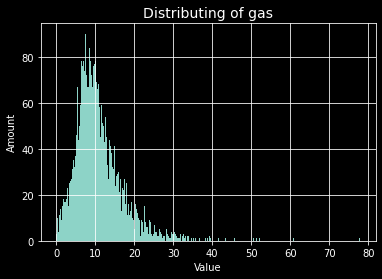

In [48]:
gas['gas'].hist(bins=300)
plt.xlabel('Value')
plt.ylabel('Amount')
plt.title('Distributing of gas', size=14);

In [49]:
gas.describe()

key          gas
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

In [50]:
for i in range(77,100,2):
    print(f' percentile {i}:', round(np.percentile(gas.gas, i), 2))

 percentile 77: 14.22
 percentile 79: 14.67
 percentile 81: 15.2
 percentile 83: 15.83
 percentile 85: 16.44
 percentile 87: 17.27
 percentile 89: 18.0
 percentile 91: 19.18
 percentile 93: 20.63
 percentile 95: 22.63
 percentile 97: 25.29
 percentile 99: 31.56


Наблюдаются слишком высокие значения,вероятно вызваны сбоями или экспериментами, могут негативно сказаться на обучении модели. Оригинальный датасет оставим неизменным, создадим дополнительный, в итоге можно будет пользоваться любым на выбор, пока будем пользоваться новым. Посчитаем и удалим выбросы в новом датасете. 

In [51]:
gas[gas['gas']>31.5].count()[0]

33

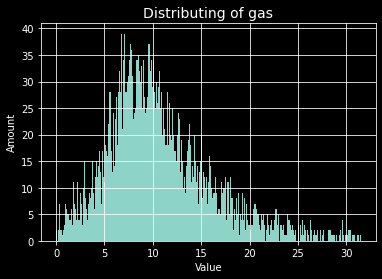

In [52]:
gas_cleared = gas.copy()
gas_cleared = gas_cleared.drop(gas_cleared[gas_cleared['gas']>31.5].index, axis=0)
gas_cleared['gas'].hist(bins=300)
plt.xlabel('Value')
plt.ylabel('Amount')
plt.title('Distributing of gas', size=14);

In [53]:
keys['gas'] = gas_cleared.key.nunique()
keys

{'electrodes': 3214, 'bulk': 3129, 'bulk_time': 3129, 'gas': 3206}

Не все партии продувались газом, либо данные утеряны

- Имена изменены
- Выбросы удалены

Распределение нормальное, смещено влево.

[Вернуться к оглавлению](#s0)

## Температура (target) <a class="anchor" id="s4"></a>

In [54]:
temperature.head(20)

key         Время замера  Температура
0     1  2019-05-03 11:02:04       1571.0
1     1  2019-05-03 11:07:18       1604.0
2     1  2019-05-03 11:11:34       1618.0
3     1  2019-05-03 11:18:04       1601.0
4     1  2019-05-03 11:25:59       1606.0
5     1  2019-05-03 11:30:38       1613.0
6     2  2019-05-03 11:34:04       1581.0
7     2  2019-05-03 11:38:40       1577.0
8     2  2019-05-03 11:46:09       1589.0
9     2  2019-05-03 11:49:38       1604.0
10    2  2019-05-03 11:55:09       1602.0
11    3  2019-05-03 12:06:44       1596.0
12    3  2019-05-03 12:13:42       1597.0
13    3  2019-05-03 12:18:46       1598.0
14    3  2019-05-03 12:25:33       1599.0
15    3  2019-05-03 12:31:04       1600.0
16    3  2019-05-03 12:35:57       1599.0
17    4  2019-05-03 12:39:27       1601.0
18    4  2019-05-03 12:44:37       1623.0
19    4  2019-05-03 12:48:04       1618.0

Целевым признаком будет последний замер

Изменим имена и формат

In [55]:
temperature = temperature.rename(columns={
    'Время замера':'measuring_time',
    'Температура':'temperature'})

In [56]:
format_time(temperature, ['measuring_time'])

In [57]:
temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             18092 non-null  int64         
 1   measuring_time  18092 non-null  datetime64[ns]
 2   temperature     14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [58]:
temperature.sample(10)

key      measuring_time  temperature
14897  2661 2019-08-16 19:18:07          NaN
5262    932 2019-06-08 15:40:00       1649.0
221      40 2019-05-04 19:39:04       1601.0
14844  2653 2019-08-16 09:50:26          NaN
337      59 2019-05-05 18:37:26       1601.0
3046    545 2019-05-24 07:27:57       1601.0
13696  2453 2019-08-08 22:15:01       1578.0
5736   1021 2019-06-11 20:22:40       1571.0
4784    851 2019-06-05 18:10:15       1615.0
8125   1454 2019-06-27 05:20:25       1593.0

In [59]:
temperature[17625:17645]

key      measuring_time  temperature
17625  3153 2019-09-03 13:48:40          NaN
17626  3154 2019-09-03 14:02:26       1568.0
17627  3154 2019-09-03 14:06:21          NaN
17628  3154 2019-09-03 14:11:19          NaN
17629  3154 2019-09-03 14:16:02          NaN
17630  3154 2019-09-03 14:21:44          NaN
17631  3154 2019-09-03 14:24:48          NaN
17632  3154 2019-09-03 14:27:21          NaN
17633  3154 2019-09-03 14:30:49          NaN
17634  3155 2019-09-03 14:35:56       1581.0
17635  3155 2019-09-03 14:40:35          NaN
17636  3155 2019-09-03 14:51:51          NaN
17637  3155 2019-09-03 14:56:56          NaN
17638  3155 2019-09-03 15:03:33          NaN
17639  3156 2019-09-03 15:17:23       1584.0
17640  3156 2019-09-03 15:21:11          NaN
17641  3156 2019-09-03 15:26:59          NaN
17642  3156 2019-09-03 15:31:55          NaN
17643  3156 2019-09-03 15:35:14          NaN
17644  3157 2019-09-03 15:46:17       1630.0

Присутствует много пропусков

In [60]:
temperature.describe()

key   temperature
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

In [61]:
temperature['key'].value_counts().sort_values().head(20)

279     1
195     1
1169    2
1911    2
530     2
246     2
943     2
2582    2
2025    2
3026    2
247     2
3059    2
1281    2
2841    2
1914    2
248     2
977     2
1988    2
732     2
2738    2
Name: key, dtype: int64

In [62]:
for i in list(temperature['key'].value_counts().sort_values().index[:5]):
    display(temperature[temperature['key']==i])

key      measuring_time  temperature
1549  279 2019-05-14 10:13:01       1603.0

key      measuring_time  temperature
1105  195 2019-05-11 00:01:36       1583.0

key      measuring_time  temperature
6536  1169 2019-06-16 22:05:01       1606.0
6537  1169 2019-06-16 22:29:16       1599.0

key      measuring_time  temperature
10681  1911 2019-07-18 21:18:39       1625.0
10682  1911 2019-07-18 22:43:10       1613.0

key      measuring_time  temperature
2979  530 2019-05-23 14:49:54       1596.0
2980  530 2019-05-23 16:21:05       1581.0

Некоторые замеры выполнялись один раз. Неизвестно когда были сделаны эти замеры, в начале процесса работы или в конце. Их следует удалить.

In [63]:
temperature = temperature.drop(index=[1549, 1105], axis=0)

In [64]:
temperature['key'].value_counts().sort_values()

49       2
732      2
1449     2
2841     2
2738     2
        ..
322     14
2567    15
1689    16
1513    16
2108    17
Name: key, Length: 3214, dtype: int64

In [65]:
check_duplicates(temperature, ['measuring_time'])

No duplicates in temperature
No duplicates in temperature[measuring_time]


Дубликатов нет

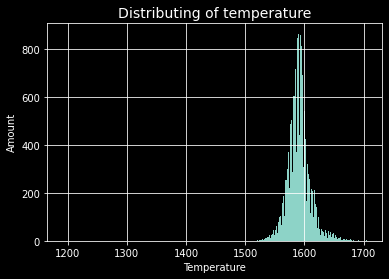

In [66]:
temperature.temperature.hist(bins=300)
plt.xlabel('Temperature')
plt.ylabel('Amount')
plt.title('Distributing of temperature', size=14);

Разброс широкий, концентрация на узком участке, предельная в районе 1580-1600. Вероятно вызвано сбоями или экспериментами, могут негативно сказаться на обучении модели. Оригинальный датасет оставим неизменным, создадим дополнительный, в итоге можно будет пользоваться любым на выбор, пока будем пользоваться новым. Посчитаем и удалим выбросы в новом датасете. 

In [67]:
for i in range(77,100,2):
    print(f' percentile {i}:', np.nanpercentile(temperature.temperature, i))

 percentile 77: 1601.0
 percentile 79: 1602.0
 percentile 81: 1604.0
 percentile 83: 1605.0
 percentile 85: 1608.0
 percentile 87: 1610.0
 percentile 89: 1612.0
 percentile 91: 1615.0
 percentile 93: 1618.0
 percentile 95: 1623.0
 percentile 97: 1633.0
 percentile 99: 1651.0


In [68]:
for i in range(1,23,2):
    print(f' percentile {i}:', np.nanpercentile(temperature.temperature, i))

 percentile 1: 1545.0
 percentile 3: 1557.0
 percentile 5: 1562.0
 percentile 7: 1566.0
 percentile 9: 1569.0
 percentile 11: 1571.0
 percentile 13: 1572.0
 percentile 15: 1574.0
 percentile 17: 1575.0
 percentile 19: 1576.0
 percentile 21: 1578.0


In [69]:
temperature[temperature['temperature']>1651.0].count()[0]

146

In [70]:
temperature[temperature['temperature']<1545.0].count()[0]

140

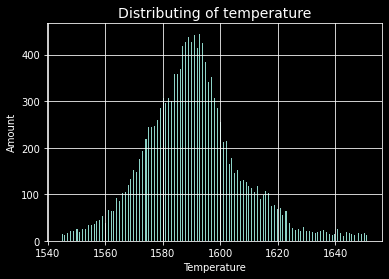

In [71]:
temperature_cleared = temperature.copy()
temperature_cleared = temperature_cleared.drop(
    temperature_cleared[temperature_cleared['temperature']>1651.0].index, axis=0)
temperature_cleared = temperature_cleared.drop(
    temperature_cleared[temperature_cleared['temperature']<1545.0].index, axis=0)
temperature_cleared['temperature'].hist(bins=300)
plt.xlabel('Temperature')
plt.ylabel('Amount')
plt.title('Distributing of temperature', size=14);

Рапределение нормальное 

- Имена изменены
- Формат времени изменен
- Обнаружено большое количество пропусков
- Обнаружены и удалены партии с одним замером
- Дубликатов нет
- Выбросы удалены

[Вернуться к оглавлению](#s0)

## Проволока (объем) <a class="anchor" id="s5"></a>

In [72]:
wire.head(20)

key      Wire 1     Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  \
0     1   60.059998        NaN     NaN     NaN     NaN     NaN     NaN   
1     2   96.052315        NaN     NaN     NaN     NaN     NaN     NaN   
2     3   91.160157        NaN     NaN     NaN     NaN     NaN     NaN   
3     4   89.063515        NaN     NaN     NaN     NaN     NaN     NaN   
4     5   89.238236   9.114560     NaN     NaN     NaN     NaN     NaN   
5     6   99.109917   9.114560     NaN     NaN     NaN     NaN     NaN   
6     7   98.061600        NaN     NaN     NaN     NaN     NaN     NaN   
7     8  155.282394        NaN     NaN     NaN     NaN     NaN     NaN   
8     9  113.393279   9.143681     NaN     NaN     NaN     NaN     NaN   
9    10   81.244796  12.376000     NaN     NaN     NaN     NaN     NaN   
10   11   99.197281        NaN     NaN     NaN     NaN     NaN     NaN   
11   12  153.578873        NaN     NaN     NaN     NaN     NaN     NaN   
12   13   77.269920  52.416003     NaN     NaN     NaN     NaN     NaN   
13   14  120.251038  37.826881     NaN     NaN     NaN     NaN     NaN   
14   15   71.285759  52.095680     NaN     NaN     NaN     NaN     NaN   
15   16  100.114563  43.097599     NaN     NaN     NaN     NaN     NaN   
16   17  110.204636  50.144638     NaN     NaN     NaN     NaN     NaN   
17   18   88.233596  32.148487     NaN     NaN     NaN     NaN     NaN   
18   19  113.218552  75.304322     NaN     NaN     NaN     NaN     NaN   
19   20  105.137756  72.275840     NaN     NaN     NaN     NaN     NaN   

    Wire 8  Wire 9  
0      NaN     NaN  
1      NaN     NaN  
2      NaN     NaN  
3      NaN     NaN  
4      NaN     NaN  
5      NaN     NaN  
6      NaN     NaN  
7      NaN     NaN  
8      NaN     NaN  
9      NaN     NaN  
10     NaN     NaN  
11     NaN     NaN  
12     NaN     NaN  
13     NaN     NaN  
14     NaN     NaN  
15     NaN     NaN  
16     NaN     NaN  
17     NaN     NaN  
18     NaN     NaN  
19     NaN     NaN

Поменяем имена

In [73]:
for i in range(1,10):
    wire = wire.rename(columns={wire.columns[i]:f'wire_{i}'})

In [74]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [75]:
wire.key.nunique()

3081

Все ключи уникальны

In [76]:
bulk.duplicated().sum()

0

Полных дубликатов нет

In [77]:
wire.describe()

key       wire_1       wire_2      wire_3      wire_4  wire_5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           wire_6     wire_7      wire_8     wire_9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [78]:
keys['wire'] = wire.key.nunique()
keys

{'electrodes': 3214,
 'bulk': 3129,
 'bulk_time': 3129,
 'gas': 3206,
 'wire': 3081}

Количество ключей опять отличается

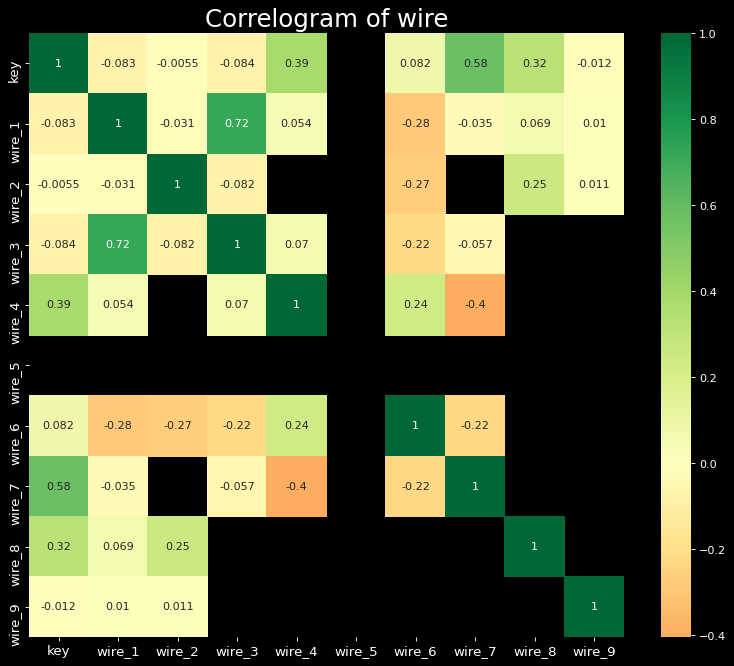

In [79]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(
    wire.corr(), 
    xticklabels=wire.corr().columns, 
    yticklabels=wire.corr().columns, 
    cmap='RdYlGn', 
    center=0, 
    annot=True)

plt.title('Correlogram of wire', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

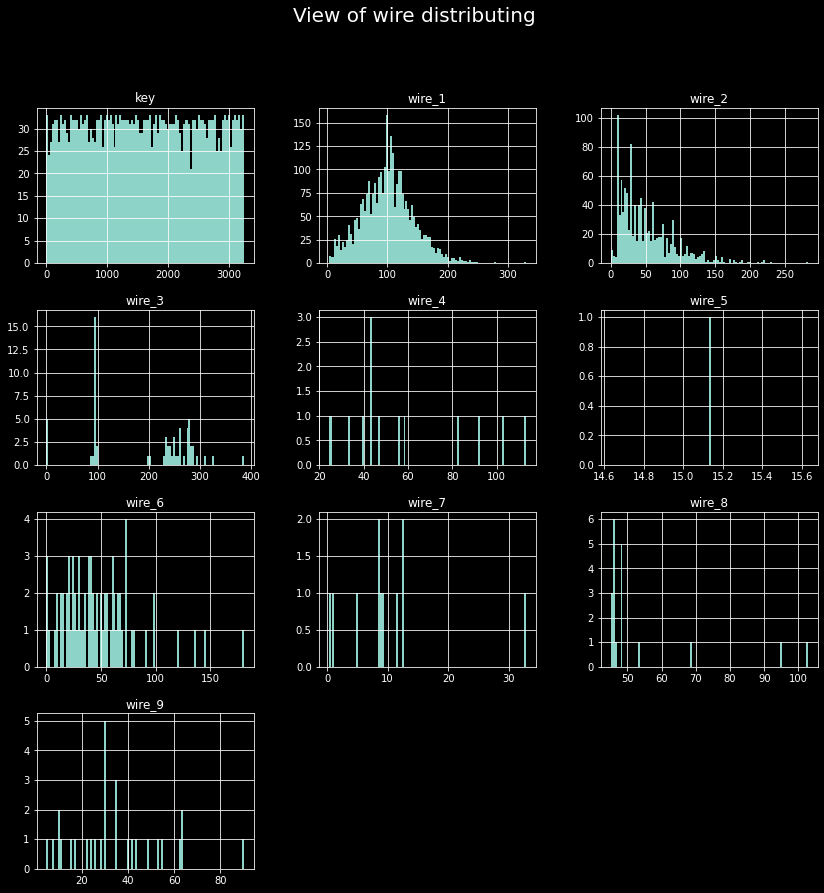

In [80]:
wire.hist(figsize=(14,14), bins=100)
plt.suptitle('View of wire distributing', size= 20);

- Имена изменены
- Ключи уникальны, что значит присадки добавляются единожды
- Дубликатов нет
- Корреляции присутствуют разной силы

В разные партии подается разное количество разных примесей

[Вернуться к оглавлению](#s0)

## Проволока (время) <a class="anchor" id="s6"></a>

In [81]:
wire_time.head(20)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0     1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1     2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2     3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3     4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4     5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5     6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6     7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   
7     8  2019-05-03 15:01:30                  NaN    NaN    NaN    NaN    NaN   
8     9  2019-05-03 15:45:44  2019-05-03 15:39:37    NaN    NaN    NaN    NaN   
9    10  2019-05-03 16:27:00  2019-05-03 16:22:36    NaN    NaN    NaN    NaN   
10   11  2019-05-03 16:55:14                  NaN    NaN    NaN    NaN    NaN   
11   12  2019-05-03 17:42:46                  NaN    NaN    NaN    NaN    NaN   
12   13  2019-05-03 18:48:32  2019-05-03 18:40:57    NaN    NaN    NaN    NaN   
13   14  2019-05-03 20:13:48  2019-05-03 20:02:42    NaN    NaN    NaN    NaN   
14   15  2019-05-03 21:07:19  2019-05-03 21:00:19    NaN    NaN    NaN    NaN   
15   16  2019-05-03 22:17:49  2019-05-03 22:07:59    NaN    NaN    NaN    NaN   
16   17  2019-05-03 23:01:58  2019-05-03 22:52:57    NaN    NaN    NaN    NaN   
17   18  2019-05-03 23:40:36  2019-05-03 23:26:15    NaN    NaN    NaN    NaN   
18   19  2019-05-04 00:57:11  2019-05-04 00:44:32    NaN    NaN    NaN    NaN   
19   20  2019-05-04 02:05:50  2019-05-04 02:00:27    NaN    NaN    NaN    NaN   

   Wire 7 Wire 8 Wire 9  
0     NaN    NaN    NaN  
1     NaN    NaN    NaN  
2     NaN    NaN    NaN  
3     NaN    NaN    NaN  
4     NaN    NaN    NaN  
5     NaN    NaN    NaN  
6     NaN    NaN    NaN  
7     NaN    NaN    NaN  
8     NaN    NaN    NaN  
9     NaN    NaN    NaN  
10    NaN    NaN    NaN  
11    NaN    NaN    NaN  
12    NaN    NaN    NaN  
13    NaN    NaN    NaN  
14    NaN    NaN    NaN  
15    NaN    NaN    NaN  
16    NaN    NaN    NaN  
17    NaN    NaN    NaN  
18    NaN    NaN    NaN  
19    NaN    NaN    NaN

In [82]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [83]:
temp = list(wire_time.columns)
temp.pop(0)
temp

['Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9']

Изменим формат времени

In [84]:
format_time(wire_time, temp)

Изменим имена

In [85]:
for i in range(1,10):
    wire_time = wire_time.rename(columns={wire_time.columns[i]:f'wire_time_{i}'})

In [86]:
temp = list(wire_time.columns)
temp.pop(0)
temp

['wire_time_1',
 'wire_time_2',
 'wire_time_3',
 'wire_time_4',
 'wire_time_5',
 'wire_time_6',
 'wire_time_7',
 'wire_time_8',
 'wire_time_9']

In [87]:
check_duplicates(wire_time, temp)

No duplicates in wire_time
No duplicates in wire_time[wire_time_1]
No duplicates in wire_time[wire_time_2]
No duplicates in wire_time[wire_time_3]
No duplicates in wire_time[wire_time_4]
No duplicates in wire_time[wire_time_5]
No duplicates in wire_time[wire_time_6]
No duplicates in wire_time[wire_time_7]
No duplicates in wire_time[wire_time_8]
No duplicates in wire_time[wire_time_9]


Дубликатов нет

In [88]:
wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   key          3081 non-null   int64         
 1   wire_time_1  3055 non-null   datetime64[ns]
 2   wire_time_2  1079 non-null   datetime64[ns]
 3   wire_time_3  63 non-null     datetime64[ns]
 4   wire_time_4  14 non-null     datetime64[ns]
 5   wire_time_5  1 non-null      datetime64[ns]
 6   wire_time_6  73 non-null     datetime64[ns]
 7   wire_time_7  11 non-null     datetime64[ns]
 8   wire_time_8  19 non-null     datetime64[ns]
 9   wire_time_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [89]:
keys['wire_time'] = wire_time.key.nunique()
keys

{'electrodes': 3214,
 'bulk': 3129,
 'bulk_time': 3129,
 'gas': 3206,
 'wire': 3081,
 'wire_time': 3081}

In [90]:
wire.query('key in @wire_time.key').count()[0]

3081

Ключи в wire и wire_time совпадают

- Имена изменены  
- Формат времени изменен
- Дубликатов нет

Присадки подаются в разное время

[Вернуться к оглавлению](#s0)

## Вывод

Во всех датасетах были изменены имена и форматы для дальнейшей удобной работы. Все датасеты были проверены на дубликаты. Дубликатов не нашлось. Ключи проверялись на уникальность и количество. **Количество ключей в разных датасетах не совпадает**. Корреляции внутри некоторых датасетов присутствуют.  
<br>
**Были обнаружены ненормальные значения:**  
1. Значение реактивной мощности: -715  
`Удалено`  
2. График распределения продувки газом показал широкий разброс значений, возможно вызваный сбоями оборудования или экспериментами на производстве. Было принято решение создать дополнительный датасет и производить дальнейшие манипуляции с ним. Данные за пределами 1 и 99 процентилей были удалены, для избежания негативного воздействия на последующее обучение модели.  
3. Температура 2-х партий измерялась только один раз. Эти партии не принесут пользы для обучения модели, наоборот могут негативно на нее повлиять, поэтому были удалены.  
4. График распределения температуры показал широкий разброс с концентрацией на узком участке и предельной концентрацией в районе 1580-1600 градусов. Возможно разброс так же вызван сбоями или экспериментами. Ситуация аналогична той, с которой мы столкнулись в процессе изучения данных по продувке газом. Соответственно решение было принято также аналогичное. Новый датасет и удаление данных за пределами 1 и 99 персентилей. 
 <br>
  <br>
<b>Графики распределения:</b> 
 <br>
- Графики распределения мощностей нагрева нормальные, смещенные влево.  
- График распределения значений продувки газом нормальный, смещенный влево (после удаления выбросов).  
- График распределения температур нормальный (после удаления выбросов). 
<br>
  <br>
<b>При осмотре датасетов было обнаружено:</b> 
 <br>
 <br>
- Не каждая партия стали проходит несколько этапов нагрева, некоторые нагреваются только один раз.  
- Большое количество пропусков в датасете замера температур, при том что время замера указано (безответственный сотрудник?).  
- В датасетах с сыпучими и проволочными легитирующими добавками ситуация схожа. Некоторые добавки коррелируют друг с другом. Вероятно они хорошо сочетаются и их часто добавляют вместе.
<br>
<br>
Больше аналитики на данный момент не получить так как нельзя соединять датасеты.

[Вернуться к оглавлению](#s0)

# Подготовка данных <a class="anchor" id="s7"></a>

Удалим пропуски в замерах температуры

In [91]:
temperature = temperature.dropna(axis=0).reset_index(drop=True)
temperature

key      measuring_time  temperature
0         1 2019-05-03 11:02:04       1571.0
1         1 2019-05-03 11:07:18       1604.0
2         1 2019-05-03 11:11:34       1618.0
3         1 2019-05-03 11:18:04       1601.0
4         1 2019-05-03 11:25:59       1606.0
...     ...                 ...          ...
14658  3237 2019-09-06 11:31:15       1569.0
14659  3238 2019-09-06 12:16:15       1584.0
14660  3239 2019-09-06 14:16:50       1598.0
14661  3240 2019-09-06 15:25:21       1617.0
14662  3241 2019-09-06 16:48:55       1586.0

[14663 rows x 3 columns]

 После удаления пропусков появились единичные замеры. Их тоже нужно удалить

In [92]:
temperature.index = temperature.key
temperature

key      measuring_time  temperature
key                                        
1        1 2019-05-03 11:02:04       1571.0
1        1 2019-05-03 11:07:18       1604.0
1        1 2019-05-03 11:11:34       1618.0
1        1 2019-05-03 11:18:04       1601.0
1        1 2019-05-03 11:25:59       1606.0
...    ...                 ...          ...
3237  3237 2019-09-06 11:31:15       1569.0
3238  3238 2019-09-06 12:16:15       1584.0
3239  3239 2019-09-06 14:16:50       1598.0
3240  3240 2019-09-06 15:25:21       1617.0
3241  3241 2019-09-06 16:48:55       1586.0

[14663 rows x 3 columns]

In [93]:
temp = temperature['key'].value_counts()
temp = list(temp[temp == 1].index)

In [94]:
temperature = temperature.drop(index=temp, axis=0)

Подготовим признаки: первый и последний замер

In [95]:
temperatures_fl = temperature.pivot_table(
    index=temperature.key, values='temperature', aggfunc=('first', 'last'))

In [96]:
temperatures_fl

first    last
key                 
1     1571.0  1613.0
2     1581.0  1602.0
3     1596.0  1599.0
4     1601.0  1625.0
5     1576.0  1602.0
...      ...     ...
2495  1570.0  1591.0
2496  1554.0  1591.0
2497  1571.0  1589.0
2498  1591.0  1594.0
2499  1569.0  1603.0

[2475 rows x 2 columns]

Начинаем собирать датасет для обучения

In [97]:
df = temperatures_fl.reset_index()
df

key   first    last
0        1  1571.0  1613.0
1        2  1581.0  1602.0
2        3  1596.0  1599.0
3        4  1601.0  1625.0
4        5  1576.0  1602.0
...    ...     ...     ...
2470  2495  1570.0  1591.0
2471  2496  1554.0  1591.0
2472  2497  1571.0  1589.0
2473  2498  1591.0  1594.0
2474  2499  1569.0  1603.0

[2475 rows x 3 columns]

Подготовим следующий признак: длительность 

In [98]:
temperatures_fl = temperature.pivot_table(
    index=temperature.key, values='measuring_time', aggfunc=('first', 'last'))
temperatures_fl

first                last
key                                         
1    2019-05-03 11:02:04 2019-05-03 11:30:38
2    2019-05-03 11:34:04 2019-05-03 11:55:09
3    2019-05-03 12:06:44 2019-05-03 12:35:57
4    2019-05-03 12:39:27 2019-05-03 12:59:47
5    2019-05-03 13:11:03 2019-05-03 13:36:39
...                  ...                 ...
2495 2019-08-10 11:27:47 2019-08-10 11:50:47
2496 2019-08-10 11:56:48 2019-08-10 12:25:13
2497 2019-08-10 12:37:26 2019-08-10 12:53:28
2498 2019-08-10 12:58:11 2019-08-10 13:23:31
2499 2019-08-10 13:33:21 2019-08-10 13:58:58

[2475 rows x 2 columns]

In [99]:
temperatures_fl['duration'] = temperatures_fl['last']-temperatures_fl['first']

In [100]:
temperatures_fl['duration'] = temperatures_fl['duration']\
.astype('timedelta64[m]').astype(int).sort_values()

In [101]:
temperatures_fl = temperatures_fl.reset_index()

In [102]:
temperatures_fl = temperatures_fl.drop(columns=['last','first'])

In [103]:
df = df.merge(temperatures_fl, left_on='key', right_on='key')

In [104]:
df

key   first    last  duration
0        1  1571.0  1613.0        28
1        2  1581.0  1602.0        21
2        3  1596.0  1599.0        29
3        4  1601.0  1625.0        20
4        5  1576.0  1602.0        25
...    ...     ...     ...       ...
2470  2495  1570.0  1591.0        23
2471  2496  1554.0  1591.0        28
2472  2497  1571.0  1589.0        16
2473  2498  1591.0  1594.0        25
2474  2499  1569.0  1603.0        25

[2475 rows x 4 columns]

Присоединим легирующие добавки

In [105]:
bulk = bulk.fillna(0)

In [106]:
df = df.merge(bulk, how='inner', left_on='key', right_on='key')

In [107]:
df

key   first    last  duration  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  \
0        1  1571.0  1613.0        28     0.0     0.0     0.0    43.0     0.0   
1        2  1581.0  1602.0        21     0.0     0.0     0.0    73.0     0.0   
2        3  1596.0  1599.0        29     0.0     0.0     0.0    34.0     0.0   
3        4  1601.0  1625.0        20     0.0     0.0     0.0    81.0     0.0   
4        5  1576.0  1602.0        25     0.0     0.0     0.0    78.0     0.0   
...    ...     ...     ...       ...     ...     ...     ...     ...     ...   
2402  2495  1570.0  1591.0        23     0.0     0.0    21.0     0.0     0.0   
2403  2496  1554.0  1591.0        28     0.0     0.0     0.0    63.0     0.0   
2404  2497  1571.0  1589.0        16     0.0     0.0     0.0    85.0     0.0   
2405  2498  1591.0  1594.0        25     0.0     0.0    90.0     0.0     0.0   
2406  2499  1569.0  1603.0        25     0.0     0.0    47.0     0.0     0.0   

      bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  \
0        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
1        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
2        0.0     0.0     0.0     0.0      0.0      0.0    205.0      0.0   
3        0.0     0.0     0.0     0.0      0.0      0.0    207.0      0.0   
4        0.0     0.0     0.0     0.0      0.0      0.0    203.0      0.0   
...      ...     ...     ...     ...      ...      ...      ...      ...   
2402     0.0     0.0     0.0     0.0     90.0      0.0    256.0      0.0   
2403     0.0     0.0     0.0     0.0    122.0      0.0    256.0      0.0   
2404     0.0     0.0     0.0     0.0      0.0      0.0    230.0      0.0   
2405     0.0     0.0     0.0     0.0    101.0      0.0    206.0      0.0   
2406     0.0     0.0     0.0     0.0      0.0      0.0    233.0      0.0   

      bulk_14  bulk_15  
0       150.0    154.0  
1       149.0    154.0  
2       152.0    153.0  
3       153.0    154.0  
4       151.0    152.0  
...       ...      ...  
2402    129.0    223.0  
2403    129.0    226.0  
2404    124.0    226.0  
2405    129.0    207.0  
2406    126.0    227.0  

[2407 rows x 19 columns]

In [108]:
wire = wire.fillna(0)

In [109]:
df = df.merge(wire, how='inner', left_on='key', right_on='key')

In [110]:
df

key   first    last  duration  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  \
0        1  1571.0  1613.0        28     0.0     0.0     0.0    43.0     0.0   
1        2  1581.0  1602.0        21     0.0     0.0     0.0    73.0     0.0   
2        3  1596.0  1599.0        29     0.0     0.0     0.0    34.0     0.0   
3        4  1601.0  1625.0        20     0.0     0.0     0.0    81.0     0.0   
4        5  1576.0  1602.0        25     0.0     0.0     0.0    78.0     0.0   
...    ...     ...     ...       ...     ...     ...     ...     ...     ...   
2326  2495  1570.0  1591.0        23     0.0     0.0    21.0     0.0     0.0   
2327  2496  1554.0  1591.0        28     0.0     0.0     0.0    63.0     0.0   
2328  2497  1571.0  1589.0        16     0.0     0.0     0.0    85.0     0.0   
2329  2498  1591.0  1594.0        25     0.0     0.0    90.0     0.0     0.0   
2330  2499  1569.0  1603.0        25     0.0     0.0    47.0     0.0     0.0   

      bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  \
0        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
1        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
2        0.0     0.0     0.0     0.0      0.0      0.0    205.0      0.0   
3        0.0     0.0     0.0     0.0      0.0      0.0    207.0      0.0   
4        0.0     0.0     0.0     0.0      0.0      0.0    203.0      0.0   
...      ...     ...     ...     ...      ...      ...      ...      ...   
2326     0.0     0.0     0.0     0.0     90.0      0.0    256.0      0.0   
2327     0.0     0.0     0.0     0.0    122.0      0.0    256.0      0.0   
2328     0.0     0.0     0.0     0.0      0.0      0.0    230.0      0.0   
2329     0.0     0.0     0.0     0.0    101.0      0.0    206.0      0.0   
2330     0.0     0.0     0.0     0.0      0.0      0.0    233.0      0.0   

      bulk_14  bulk_15      wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  \
0       150.0    154.0   60.059998   0.00000     0.0     0.0     0.0     0.0   
1       149.0    154.0   96.052315   0.00000     0.0     0.0     0.0     0.0   
2       152.0    153.0   91.160157   0.00000     0.0     0.0     0.0     0.0   
3       153.0    154.0   89.063515   0.00000     0.0     0.0     0.0     0.0   
4       151.0    152.0   89.238236   9.11456     0.0     0.0     0.0     0.0   
...       ...      ...         ...       ...     ...     ...     ...     ...   
2326    129.0    223.0   89.150879   0.00000     0.0     0.0     0.0     0.0   
2327    129.0    226.0  114.179527   0.00000     0.0     0.0     0.0     0.0   
2328    124.0    226.0   94.086723   9.04800     0.0     0.0     0.0     0.0   
2329    129.0    207.0  118.110717   0.00000     0.0     0.0     0.0     0.0   
2330    126.0    227.0  110.160958  50.00528     0.0     0.0     0.0     0.0   

      wire_7  wire_8  wire_9  
0        0.0     0.0     0.0  
1        0.0     0.0     0.0  
2        0.0     0.0     0.0  
3        0.0     0.0     0.0  
4        0.0     0.0     0.0  
...      ...     ...     ...  
2326     0.0     0.0     0.0  
2327     0.0     0.0     0.0  
2328     0.0     0.0     0.0  
2329     0.0     0.0     0.0  
2330     0.0     0.0     0.0  

[2331 rows x 28 columns]

Присоединим газ

In [111]:
df = df.merge(gas, how='inner', left_on='key', right_on='key')

Присоединим данные о электродах

In [112]:
temp = electrodes.groupby('key',as_index=False).sum()

In [113]:
temp

key  active_power  reactive_power
0        1      3.036730        2.142821
1        2      2.139408        1.453357
2        3      4.063641        2.937457
3        4      2.706489        2.056992
4        5      2.252950        1.687991
...    ...           ...             ...
3209  3237      2.541872        2.025417
3210  3238      1.374821        1.038103
3211  3239      4.848005        3.541541
3212  3240      3.317679        2.373552
3213  3241      3.045283        2.140011

[3214 rows x 3 columns]

In [114]:
df = df.merge(temp, how='inner', left_on='key', right_on='key')

In [115]:
df

key   first    last  duration  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  \
0        1  1571.0  1613.0        28     0.0     0.0     0.0    43.0     0.0   
1        2  1581.0  1602.0        21     0.0     0.0     0.0    73.0     0.0   
2        3  1596.0  1599.0        29     0.0     0.0     0.0    34.0     0.0   
3        4  1601.0  1625.0        20     0.0     0.0     0.0    81.0     0.0   
4        5  1576.0  1602.0        25     0.0     0.0     0.0    78.0     0.0   
...    ...     ...     ...       ...     ...     ...     ...     ...     ...   
2324  2495  1570.0  1591.0        23     0.0     0.0    21.0     0.0     0.0   
2325  2496  1554.0  1591.0        28     0.0     0.0     0.0    63.0     0.0   
2326  2497  1571.0  1589.0        16     0.0     0.0     0.0    85.0     0.0   
2327  2498  1591.0  1594.0        25     0.0     0.0    90.0     0.0     0.0   
2328  2499  1569.0  1603.0        25     0.0     0.0    47.0     0.0     0.0   

      bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  \
0        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
1        0.0     0.0     0.0     0.0      0.0      0.0    206.0      0.0   
2        0.0     0.0     0.0     0.0      0.0      0.0    205.0      0.0   
3        0.0     0.0     0.0     0.0      0.0      0.0    207.0      0.0   
4        0.0     0.0     0.0     0.0      0.0      0.0    203.0      0.0   
...      ...     ...     ...     ...      ...      ...      ...      ...   
2324     0.0     0.0     0.0     0.0     90.0      0.0    256.0      0.0   
2325     0.0     0.0     0.0     0.0    122.0      0.0    256.0      0.0   
2326     0.0     0.0     0.0     0.0      0.0      0.0    230.0      0.0   
2327     0.0     0.0     0.0     0.0    101.0      0.0    206.0      0.0   
2328     0.0     0.0     0.0     0.0      0.0      0.0    233.0      0.0   

      bulk_14  bulk_15      wire_1    wire_2  wire_3  wire_4  wire_5  wire_6  \
0       150.0    154.0   60.059998   0.00000     0.0     0.0     0.0     0.0   
1       149.0    154.0   96.052315   0.00000     0.0     0.0     0.0     0.0   
2       152.0    153.0   91.160157   0.00000     0.0     0.0     0.0     0.0   
3       153.0    154.0   89.063515   0.00000     0.0     0.0     0.0     0.0   
4       151.0    152.0   89.238236   9.11456     0.0     0.0     0.0     0.0   
...       ...      ...         ...       ...     ...     ...     ...     ...   
2324    129.0    223.0   89.150879   0.00000     0.0     0.0     0.0     0.0   
2325    129.0    226.0  114.179527   0.00000     0.0     0.0     0.0     0.0   
2326    124.0    226.0   94.086723   9.04800     0.0     0.0     0.0     0.0   
2327    129.0    207.0  118.110717   0.00000     0.0     0.0     0.0     0.0   
2328    126.0    227.0  110.160958  50.00528     0.0     0.0     0.0     0.0   

      wire_7  wire_8  wire_9        gas  active_power  reactive_power  
0        0.0     0.0     0.0  29.749986      3.036730        2.142821  
1        0.0     0.0     0.0  12.555561      2.139408        1.453357  
2        0.0     0.0     0.0  28.554793      4.063641        2.937457  
3        0.0     0.0     0.0  18.841219      2.706489        2.056992  
4        0.0     0.0     0.0   5.413692      2.252950        1.687991  
...      ...     ...     ...        ...           ...             ...  
2324     0.0     0.0     0.0   7.125735      3.168133        2.210936  
2325     0.0     0.0     0.0   9.412616      4.174918        2.872031  
2326     0.0     0.0     0.0   6.271699      3.605239        2.452092  
2327     0.0     0.0     0.0  14.953657      3.202310        2.239820  
2328     0.0     0.0     0.0  11.336151      1.737084        1.296836  

[2329 rows x 31 columns]

Полный датасет собран, теперь посмотрим корреляции

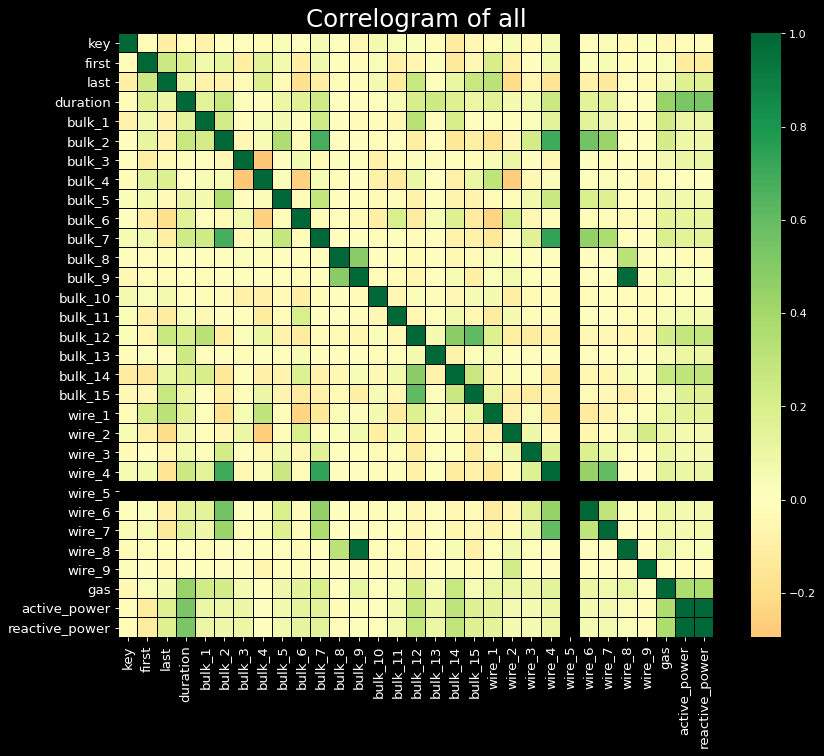

In [116]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(
    df.corr(), 
    xticklabels=df.corr().columns, 
    yticklabels=df.corr().columns, 
    cmap='RdYlGn', 
    center=0, 
    annot=False,
    linewidths=0.01,
    linecolor='black')

plt.title('Correlogram of all', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [117]:
df.wire_5.unique()

array([0.])

Черные полосы означают отсутствие данных. Удалим этот столбец и вместе с ним теперь лишний key. Переименуем столбцы с замерами температур для большей ясности и установим удобный порядок.


In [118]:
df = df.drop(columns=['wire_5', 'key'], axis=1)

In [119]:
df = df.rename(columns={
    'first':'first_temperature',
    'last':'last_temperature'})

In [120]:
df = df[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 
              'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 
              'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3',
              'wire_4', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'gas', 
              'active_power', 'reactive_power', 'duration', 'first_temperature', 
              'last_temperature']]

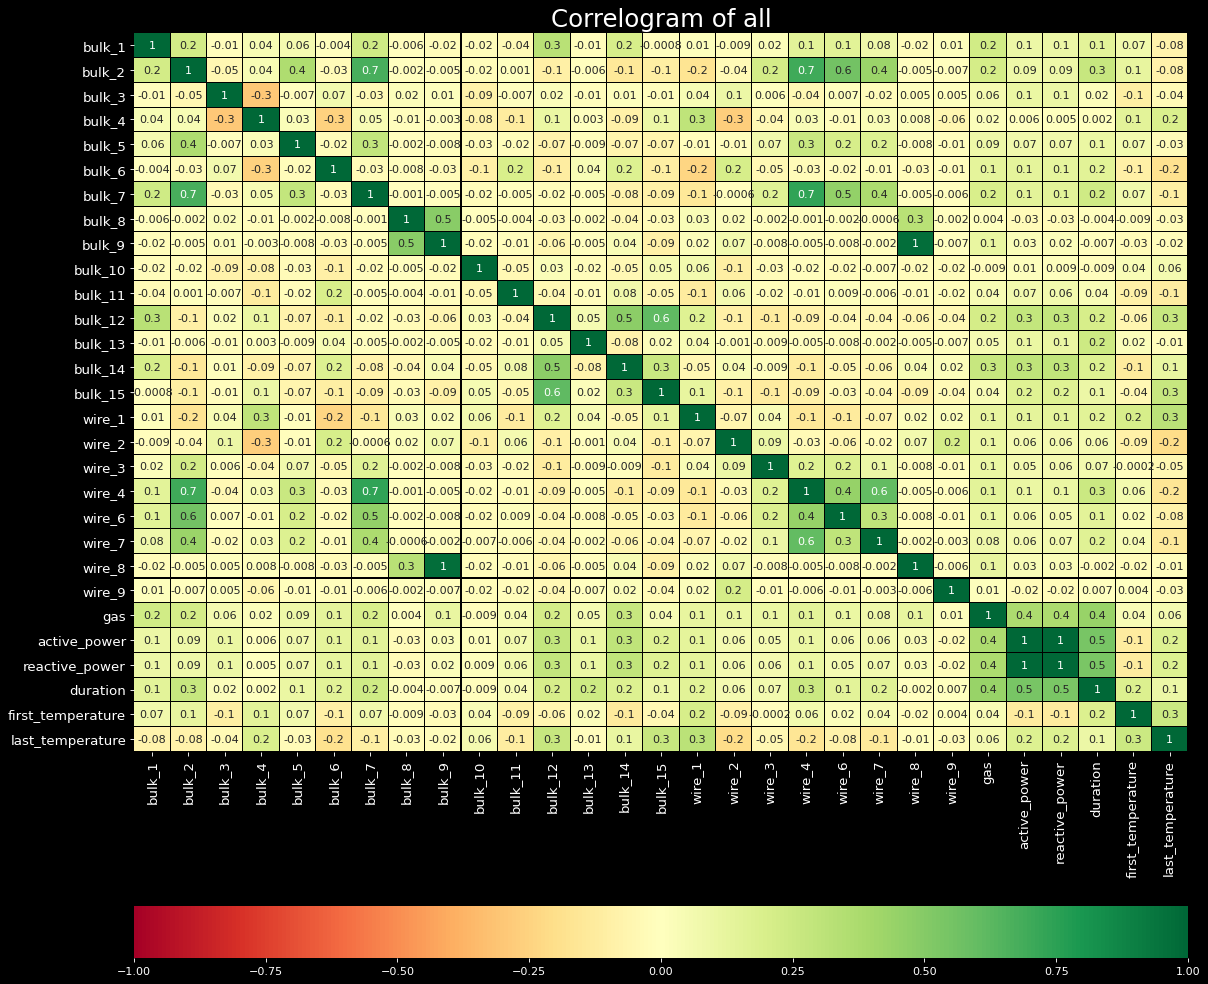

In [121]:
plt.figure(figsize=(17,17), dpi= 80)
sns.heatmap(
    df.corr(), 
    xticklabels=df.corr().columns, 
    yticklabels=df.corr().columns, 
    cmap='RdYlGn', 
    center=0, 
    annot=True,
    linewidths=0.03,
    linecolor='black',
    fmt='.1g',
    vmin=-1,
    vmax=1,
    cbar_kws= {'orientation': 'horizontal'}
    )

plt.title('Correlogram of all', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [122]:
X = add_constant(df)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds)

const                27315.646567
bulk_1                   1.400198
bulk_2                   2.942750
bulk_3                   1.171459
bulk_4                   1.430119
bulk_5                   1.168961
bulk_6                   1.324099
bulk_7                   2.718049
bulk_8                   3.727740
bulk_9                  67.566669
bulk_10                  1.074622
bulk_11                  1.072297
bulk_12                  2.580438
bulk_13                  1.109583
bulk_14                  1.659838
bulk_15                  1.793083
wire_1                   1.469402
wire_2                   1.251191
wire_3                   1.127738
wire_4                   3.518514
wire_6                   1.516109
wire_7                   1.637119
wire_8                  57.019832
wire_9                   1.063396
gas                      1.480920
active_power            68.149658
reactive_power          67.169635
duration                 1.980615
first_temperature        1.318273
last_temperatu

График корреляций и коэффициент инфляции дисперсии показывают присутствие мультиколлинеарности, особенно сильная связь между двумя парами active_power-reactive_power и bulk_9-wire_8. В остальных случаях VIF ниже 5, значит об этих признаках можно не беспокоиться. Вместо удаления active_power-reactive_power и bulk_9-wire_8 выберем модели машинного обучения способные работать со случаями мультиколлинеарности. (лично проведенные эксперименты показали падение итоговой метрики при удалении этих признаков)

Датасет выглядит удовлетворительно, перейдем к разделению на выбороки

In [123]:
features_x, features_y,\
target_x, target_y = train_test_split(
    df.drop(columns=['last_temperature'], axis=1), df['last_temperature'],
    test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [124]:
print('features_x', features_x.shape)
print('features_y', features_y.shape)

features_x (1746, 28)
features_y (583, 28)


[Вернуться к оглавлению](#s0)

## Вывод <a class="anchor" id="s8"></a>

В даннном разделе были выделены температуры сплава при первом и поледнем замерах и расчитана длительность каждого этапа обработки. Далее все имеющие значение данные были собраны в один датасет и оценены корреляции внутри получившегося датасета. В результате проверки графиком корреляций и коэффициентом инфляции дисперсии была обнаружена мультиколлинеарность. Сильная корреляция наблюдается между двумя парами признаков active_power-reactive_power и bulk_9-wire_8. Было принято решение не удалять данные признаки, а использовать подходящие алгоритмы машинного обучения. Убедившись что в данных нет пропусков, аномалий, дубликатов и прочих ненормальных значений был сделан вывод что такие данные можно использовать для обучения моделей, датасет был разделен на тренировочную и тестовую выборки.

[Вернуться к оглавлению](#s0)

# Обучение моделей <a class="anchor" id="s9"></a>

In [125]:
model_r = Ridge(random_state=RANDOM_STATE)
grid_params = [
    {'solver':[
        'auto',
        'svd',
        'cholesky',
        'lsqr',
        'sparse_cg',
        'sag',
        'saga',
        'lbfgs'], 
     'alpha': [1,0.1,0.01,0.001,0.0001,0], 
     "fit_intercept": [True, False]}]
grid_model_r = GridSearchCV(model_r, 
    grid_params, 
    scoring='neg_mean_absolute_error', cv=CV)
grid_model_r.fit(features_x, target_x)
print('best solver', grid_model_r.best_params_['solver'])
print('best alpha', grid_model_r.best_params_['alpha'])
print('best fit_intercept', grid_model_r.best_params_['fit_intercept'])
print("MAE =", (grid_model_r.best_score_*-1))

best solver auto
best alpha 1
best fit_intercept True
MAE = 7.324533632168496


C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_ridge.py", line 1130, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\keyten\Anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_ridge.py", l

Гребневая регрессия с кросс-валидацией показывает оценку MAE 7,32

In [126]:
model_c = CatBoostRegressor(random_state=RANDOM_STATE)
grid_params = {
    'depth': np.arange(4, 11, 1),
    'learning_rate' : [0.01,0.02,0.03,0.04],
    'iterations': np.arange(10, 101, 10)}
grid_model_c = GridSearchCV(model_c, 
    grid_params, 
    scoring='neg_mean_absolute_error', cv=CV)
grid_model_c.fit(features_x, target_x)
print('best depth', grid_model_c.best_params_['depth'])
print('best learning_rate', grid_model_c.best_params_['learning_rate'])
print('best iterations', grid_model_c.best_params_['iterations'])
print("MAE =", (grid_model_c.best_score_*-1))

0:	learn: 11.1405402	total: 56.5ms	remaining: 508ms
1:	learn: 11.1244479	total: 57.8ms	remaining: 231ms
2:	learn: 11.1086545	total: 59.2ms	remaining: 138ms
3:	learn: 11.0879528	total: 60.4ms	remaining: 90.7ms
4:	learn: 11.0703622	total: 61.7ms	remaining: 61.7ms
5:	learn: 11.0506268	total: 63.2ms	remaining: 42.1ms
6:	learn: 11.0327235	total: 64.5ms	remaining: 27.6ms
7:	learn: 11.0159135	total: 66.6ms	remaining: 16.6ms
8:	learn: 10.9991297	total: 68.1ms	remaining: 7.56ms
9:	learn: 10.9813922	total: 69.4ms	remaining: 0us
0:	learn: 10.9995748	total: 1.44ms	remaining: 13ms
1:	learn: 10.9826997	total: 2.85ms	remaining: 11.4ms
2:	learn: 10.9618585	total: 4.94ms	remaining: 11.5ms
3:	learn: 10.9424272	total: 6.03ms	remaining: 9.04ms
4:	learn: 10.9230310	total: 7.06ms	remaining: 7.06ms
5:	learn: 10.9051212	total: 8.19ms	remaining: 5.46ms
6:	learn: 10.8848186	total: 9.2ms	remaining: 3.94ms
7:	learn: 10.8674602	total: 10.2ms	remaining: 2.56ms
8:	learn: 10.8475412	total: 11.3ms	remaining: 1.25ms
9:

Градиентный бустинг с кросс-валидацией показывает оценку MAE 7,07

In [127]:
model_f = RandomForestRegressor(n_jobs=-1,random_state=RANDOM_STATE)
rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 501, step=50),
              'max_features':randint(1,56),              
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }
model_f_random = RandomizedSearchCV(
    model_f, rs_space, n_iter=200, scoring='neg_mean_absolute_error', cv=CV)
model_f_random.fit(features_x, target_x)
print('Best hyperparameters are: '+str(model_f_random.best_params_))
print('Best score is: '+str((model_f_random.best_score_*-1)))

Best hyperparameters are: {'max_depth': 10, 'max_features': 53, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 160}
Best score is: 7.017422025550879


In [132]:
model_f = RandomForestRegressor(
    n_jobs=-1,    
    min_samples_leaf = 2,
    min_samples_split = 4,
    random_state=RANDOM_STATE
)
grid_params = [{
    'max_depth': np.arange(8, 12),
    'max_features':np.arange(50,56),    
    'n_estimators': np.arange(140, 181, 5)}]
grid_model_f = GridSearchCV(model_f, 
    grid_params, 
    scoring='neg_mean_absolute_error', cv=CV)
grid_model_f.fit(features_x, target_x)
print('Best hyperparameters are: '+str(grid_model_f.best_params_))
print('Best score is: '+str((grid_model_f.best_score_*-1)))

Best hyperparameters are: {'max_depth': 10, 'max_features': 50, 'min_samples_split': 4, 'n_estimators': 140}
Best score is: 7.013739230547029


Ансамбль решающих деревьев с кросс-валидацией показывает оценку MAE 7,01

In [128]:
# КОД ТИМЛИДА
params = {'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 140}
model = RandomForestRegressor(
    n_jobs=-1,    
    min_samples_leaf = 2,
    random_state=RANDOM_STATE,
    **params
)
model.fit(features_x, target_x)
model_pred = model.predict(features_y)
print(mean_absolute_error(target_y, model_pred))

6.669564348831926


In [133]:
grid_model_f_pred = grid_model_f.predict(features_y)
print(mean_absolute_error(target_y, grid_model_f_pred))

6.674951885284356


Лучшая модель ансамбль решающих деревьев показывает оценку MAE 6.67 на тестовой выборке

[Вернуться к оглавлению](#s0)

## Проверка на адекватность <a class="anchor" id="s10"></a>

In [130]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_x, target_x)
dummy_predict = dummy_model.predict(target_y)
print(mean_absolute_error(target_y, dummy_predict))

8.136761507311968


Проверка подтвердила адекватность модели

[Вернуться к оглавлению](#s0)

## Значимость признаков <a class="anchor" id="s11"></a>

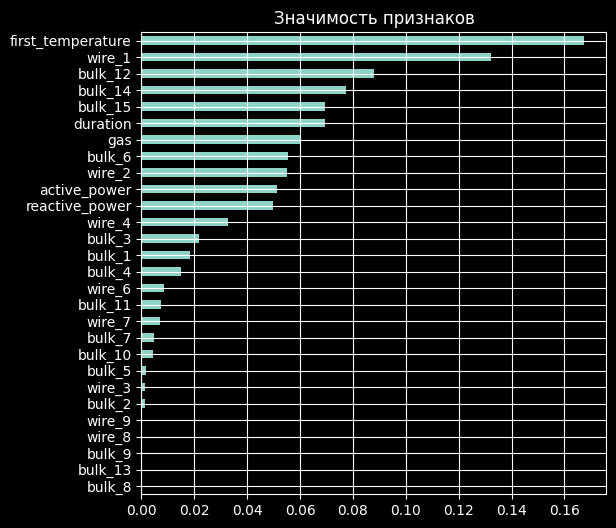

In [134]:
pd.DataFrame(data={'score': grid_model_f.best_estimator_.feature_importances_}, 
                      index=features_x.columns).sort_values(by='score')\
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False)
plt.title('Значимость признаков');

На данном графике мы можем наглядно видеть какое влияние имеет каждый признак на результаты работы модели. first_temperature на первом месте вполне ожидаемо, но на удивление wire_1 и bulk_12 оказались важнее duration и power.

[Вернуться к оглавлению](#s0)

## Вывод <a class="anchor" id="s12"></a>

Были обучены 3 различных модели с использованием кросс-валидации. На тестовой выборке они показали следующие результаты МАЕ:
- Гребневая регрессия - 7,32
- Градиентный бустинг - 7,07
- Ансамбль решающих деревьев - 7,01

Так как ансамбль решающих деревьев показал лучший результат, он был выбран для тестирования на тестовой выборке. Результат MAE составил 6.63 градуса что удовлетворяет требованиям точности. Далее модель прошла проверку адекватности и успешно с ней справилась. Также был представлен график значимости признаков, который показал что first_temperature, wire_1 и bulk_12  важнее duration и power.

[Вернуться к оглавлению](#s0)

# Отчет

### Отчет по задаче создания модели машинного обучения для предсказания температуры стали.

**Оглавление**

1. Начальные данные
2. Требования заказчика
3. Наблюдения
4. Обнаруженные ненормальные значения
5. Принятые решения
6. Совершенные действия
7. Результат
8. Ответы на вопросы задания  
----------------------------------------------------------------------------------------------------
    
1. **Начальные данные:**

- Расплавленная сталь заливается в ковш (данные об объеме и типе стали отсутствуют)
- Подогревается электродами (данные о работе элетродов есть)
- Измеряется температура (данные есть)
- Из сплава выводится сера (данные отсутствуют)
- Измеряется температура стали (данные есть)
- Производится химический анализ (данные отсутствуют)
- Добавлением примесей корректируется химический состав (данные есть)
- Подогревается электродами (данные о работе элетродов есть)
- Добавляются легирующие примеси (данные есть)
- Сплав продувается инертным газом (данные есть)
- Измеряется температура (данные есть)
- Цикл повторяется до достижения целевого химического состава и оптимальной температуры
- Готовый продукт выходит в виде заготовок-слябов
----------------------------------------------------------------------------------------------------

2. **Требования заказчика:**

- Оценка качества модели по метрике MAE
- Минимальный порог MAE - 6,8
- random_state = 150523 для воспроизводимости результатов
- Отбор партий с полной информацией
- Выводу по каждому этапу работы
- Разделение train:test - 3:1
- Использование кросс-валидации
- Проверка только одной модели на тестовой выборке
- Проверка на адекватность с константной моделью
- Представить значимость признаков
- Пояснять изменения датасета
----------------------------------------------------------------------------------------------------

3.**Наблюдения:**

- Полные данные предоставлены на 2329 партий
- Некоторые партии проходили только 1 этап нагрева (вероятно ошибка в данных так как это не соответствует техническому процессу)
- Максимальное количество этапов нагрева - 16
- Корреляции внутри некоторых датасетов присутствуют до их объединения (данные связаны: увеличение одного влечет увеличение другого или наоборот).
- Графики распределения мощностей смещены влево(большее количество значений ниже медианы).
- График распределения значений продувки газом смещен влево (после удаления выбросов).
- График распределения температур нормален (после удаления выбросов)(большинство значений близки к медиане - 1590 градусов)
- Большое количество пропусков в датасете замера температур, при том что время замера указано
- В датасетах с сыпучими и проволочными легитирующими добавками некоторые материалы коррелируют друг с другом. Вероятно они хорошо сочетаются и их часто добавляют вместе.
- В обобщеном датасете подтверждена мультиколлинеарность(корреляция данных друг с другом, не с целевым признаком) 
----------------------------------------------------------------------------------------------------

4. **Обнаруженные ненормальные значения:**

- Значение реактивной мощности: -715 (удалено)
- Графики распределения продувки газом и замеров температуры показали широкий разброс значений, возможно вызваный сбоями оборудования или экспериментами на производстве.  
- Температура некоторых партий измерялась только один раз.
- Не все партии продувались газом, либо данные утеряны
----------------------------------------------------------------------------------------------------

5. **Принятые решения:**

- Для кросс-валидации использовать размер в 5 батчей.
- Не удалять коррелирующие данные
- Использовать модели машинного обучения способные работать со случаями мультиколлинеарности
	- Гребневая регрессия Ridge
	- Градиентный бустинг CatBoostRegressor
	- Ансамбль решающих деревьев RandomForestRegressor
- Лучшей моделью оказалась RandomForestRegressor
----------------------------------------------------------------------------------------------------

6. **Совершенные действия:**

- Все названия столбцов в данных были изменены с русского языка на английский с соблюдением стандартов snake_case (нижний регистр, разделение нижним подчеркиванием)
- Форматы данных были изменены на более подходящие
- Все датасеты были проверены на дубликаты - дубликатов не нашлось(повторы)
- Ключи(номера партий) проверялись на уникальность и количество - количество ключей в разных датасетах не совпадает, уникальность подтверждена.
- Созданы дополнительные датасеты для продувки газом и замеров температуры. Данные за пределами 1 и 99 процентилей удалены, для избежания негативного воздействия на последующее обучение модели.
- Удалены партии в которых проводился только 1 замер температуры
- Удалены пропуски в замерах температуры
- Выделены температуры сплава при первом и последнем замерах и расчитана длительность каждого этапа обработки
- Потребляемая электродами электроэнергия суммированна для каждой партии, разделение на активную и реактивную оставлено нетронутым 
- Создан датасет, обобщающий всю необходимую для обучения модели информацию
- Проанализированы корреляции в обобщеном датасете при помощи графика корреляций и коэффициента инфляции дисперсии. Обнаружена сильная связь между двумя парами active_power-reactive_power и bulk_9-wire_8
- Данные разделены на обучающую и тестовую выборки согласно указаниям заказчика 
- Обучены 3 модели машинного обучения с использованием кросс-валидации согласно указаниям заказчика
- Оценены результаты работы моделей на тренировочной выборке метрикой MAE согласно указаниям заказчика
	- Ridge: 7,32
	- CatBoostRegressor: 7,07
	- RandomForestRegressor: 7,01
- Проведена проверка на тестовой выборке 
- оценка MAE = 6,67
- Проведена проверка модели на адекватность с использованием константной модели DummyRegressor. Адекватность модели RandomForestRegressor подтверждена
- Проведена и визуализирована оценка значимости всех признаков, использованных при обучении модели. В результате первые три места заняли first_temperature, wire_1 и bulk_12.
----------------------------------------------------------------------------------------------------

7. **Результат:**  

Лучшая модель RandomForestRegressor показывает оценку MAE на тестовой выборке 6,67 с параметрами:
- batch_size: 5
- random_state: 150523
- max_depth: 10
- max_features: 50
- min_samples_leaf: 2
- min_samples_split: 4
- n_estimators: 140
- n_jobs:-1  

Для обучения использовались признаки (по убыванию значимости):
- first_temperature
- wire_1
- bulk_12
- bulk_14 
- bulk_15
- duration
- gas
- bulk_6
- wire_2
- active_power
- reactive_power
- wire_4
- bulk_3
- bulk_1
- bulk_4
- wire_6 
- bulk_11
- wire_7
- bulk_7
- bulk_10
- bulk_5
- wire_3 
- bulk_2
- wire_9
- wire_8
- bulk_9
- bulk_13
- bulk_8
----------------------------------------------------------------------------------------------------

8. **Ответы на вопросы задания**

> *Какие пункты плана были выполнены, а какие — нет. Почему?*  

\-  Все пункты плана были выполнены, потому что так и планировалось (иначе для чего план)

> *Какие трудности возникли и как вы их преодолели?*  

\- При столкновении с мультиколлинеарностью дал знать о себе недостаток знаний, пришлось изучать в интернете что это такое. Также и с значимостью признаков, раньше это была незнакомая тема.

> *Какие ключевые шаги в решении задачи вы выделили?*  

\- Изучение данных -> нахождение целевого признака -> подготовка данных -> обучение моделей -> проверка финальной модели

> *Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?*  

\- Все кроме времени, wire_5 и key. Дополнительно из времени создал признак показывающий время тех. процесса. Из признаков вычищал пропуски удалением, либо заменой на нули, удалил явно ошибочные значения и значения выходящие за 1 и 99 процентили, удалил единичные замеры температуры.

> *Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?*  

\- RandomForestRegressor {'max_depth': 10, 'max_features': 50, 'min_samples_split': 4, 'n_estimators': 140, 'random_state': 150523, 'min_samples_leaf': 2, 'n_jobs':-1 } - МАЕ = 6,67


[Вернуться к оглавлению](#s0)